# Laboratorio 05: Cálculo Numérico.

---
### Profesor: Daniel Ruiz Mejía
### Nombre: Benjamín Escobar Jaramillo
*Métodos computacionales 2025-I*

---

In [ ]:
#@title Librerias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy as sp
from scipy.interpolate import CubicSpline
from scipy.integrate import quad,trapezoid,simpson,dblquad
from scipy.special import roots_legendre

# 1.

En un cirtcuito con un voltaje de  $\varepsilon(t)$ y una inductancia de $L$, la primera ley de Kirchhoff nos da la siguiente relación

$$
\varepsilon(t) = L\frac{\mathrm{d}i}{\mathrm{d}t} + Ri
$$

donde $R$, es la resistencia del ciruito, $I$ es la corriente. Suponga que medimos la corriente con varios valores de $t$ y obtenemos:

```
t = np.array([1.00, 1.01, 1.02, 1.03, 1.04])  # tiempo
i = np.array([3.10, 3.12, 3.14, 3.18, 3.24])  # corriente
```


donde $t$ se mide en segundos, $I$ se da en Amperios, la inductancia $L= 0.98$ H y la resistencia es de 0.142 $\Omega$. Aproxime el votaje  $\varepsilon(t)$ en los valores t=1.00, 1.01, 1.02, 1.03, 1.04 ,  para ello realice lo siguiente:


- Construya un data frame de pandas con los valores de tiempo y corriente
- Emplee el metodo de diferencias finitas y de tres puntos para calcular la derivada numérica.
- Ahora, encuentre un polinomio de interpolación usando alguno de los métodos vistos y calcule la derivada 'exacta'. Compare sus resultados.

In [ ]:
#Bien! comencemos esta travesía de integración y diferenciación!ç

#0) Datos estandar
L=0.98
R=0.142
#A) DataFrame.
t = np.array([1.00, 1.01, 1.02, 1.03, 1.04])
i = np.array([3.10, 3.12, 3.14, 3.18, 3.24])
dats={'Tiempo':t,'Corriente':i}
tvsi=pd.DataFrame(dats) #tvsi= tiempo(t) vs corriente (i)
tvsi

,Tiempo,Corriente
0,1.00,3.10
1,1.01,3.12
2,1.02,3.14
3,1.03,3.18
4,1.04,3.24


In [ ]:
### Bien! Ahora implementemos nuestro metodos de finitas y de 3 puntos!!
#A) Note que por el caracter del tiempo, nuestro paso (h) será estandar de 0.01


def NUMfinitas(x,h=0.01):  #(un h estandarizado por el tiempo)
  ''' Calcula las diferencias finitas, empleando; atras, adelante y centro.
  Entradas:
    -x: Puntos a derivar (arraylike)
    -h: float
  Salidas:
    -dx/dt(derivada, arraylike)
  '''

  n=len(x)
  fprime=np.zeros_like(x,dtype=float)       #Con esto vectorizamos y ahorramos recursos

  for i in range(n):

    if i==0:
      fprime[i]= ((  ((x[i+1]) - (x[i]))   / h))

    elif i==n-1:
      fprime[i]=((  (  (x[i]) - (x[i-1])  ) / h))     #Y aqui, diferenciamos la posición

    else:
      fprime[i]=(( ( ((x[i+1])) - ((x[i-1]))   ) )/(2*h))

  return fprime


#Perfecto! Ahora vamos a ver 3 puntos!!

def NUMdydx3p(x,h=0.01): #Funcionamiento analogo, con el h asociado al t

  ''' Calcula la derivada nùmerica usando el metodo de 3 puntos, empleando; atras, adelante y centro.
  Entradas:
    -x: Puntos a derivar (arraylike)
    -h: paso (float)
  Salidas:
    -fprime(derivada, arraylike)
  '''

  n=len(x)
  fprime=np.zeros_like(x,dtype=float) #mismo metodo....

  for i in range(n):

    if i==0:
      fprime[i]=  ((-3)*((x[i])) + 4*((x[i+1])) + (-1)*((x[i+2])) )/(2*h)



    elif i==n-1:
      fprime[i]=   (3*((x[i])) -  4*((x[i-1]))  +  ((x[i-2])) )/(2*h)



    else:
      fprime[i]=(( ( ((x[i+1])) - ((x[i-1]))   ) )/(2*h))

  return fprime

#Perfecto! Veamos nuestros datos ya analizados!!

In [ ]:
fin,tresp=NUMfinitas(i),NUMdydx3p(i)

Text(0.5, 1.0, '$di/dt$')

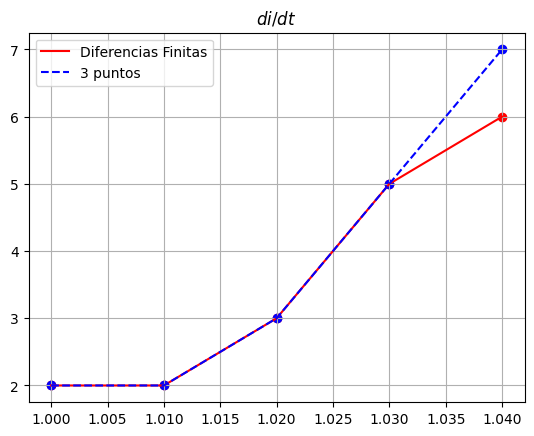

In [ ]:
plt.plot(t,fin,c='r',label='Diferencias Finitas')
plt.plot(t,tresp,c='b',label='3 puntos',ls=('--'))
plt.scatter(t,fin,c='r')
plt.scatter(t,tresp,c='b')
plt.grid()
plt.legend()
plt.title('$di/dt$')

In [ ]:
datoos={'Diferencias finitas':fin,'Tres puntos':tresp}
didtt=pd.DataFrame(datoos) #tvsi= tiempo(t) vs corriente (i)
didtt

,Diferencias finitas,Tres puntos
0,2.0,2.0
1,2.0,2.0
2,3.0,3.0
3,5.0,5.0
4,6.0,7.0


In [ ]:
'''
PERFECTO! Como bien pudimos observar, tenemos nuestros datos numericos de la derivada, aunque algo... imprecisos acaso?
(note la ausencia mismo de decimales!) Veamos si al hacer continuos nuestros metodos, obtenemos aun mayor precisión!
'''
#Plan! hacer los mismos metodos en forma continua, es decir, con una función asociada al polinomio interpolador

#B1) Diferencias finitas
def finitas(f,x,h=0.00001):  #(un h estandar para tener buena precisión)
  ''' Calcula las diferencias finitas, empleando; atras, adelante y centro.
  Entradas:
    -f: Función numérica
    -x: array
    -h: float

  Salidas:
    -fprime(derivada)
  '''
  if h==0:
    raise ValueError('Necesariamente h>0;se aconseja h>1e-10')

  n=len(x)
  fprime=np.zeros_like(x,dtype=float)       #Con esto vectorizamos y ahorramos recursos

  for i in range(n):

    if i==0:
      fprime[i]= ((  (f(x[i]+h) - f(x[i]))   / h))

    elif i==n-1:
      fprime[i]=((  (  f(x[i]) - f(x[i]-h)  ) / h))     #Y aqui, diferenciamos la posición

    else:
      fprime[i]=(( ( (f(x[i]+h)) - (f(x[i]-h))   ) )/(2*h))

  return fprime

#B2) 3 puntos
def dydx3p(f,x,h=0.00001):

  ''' Calcula la derivada nùmerica usando el metodo de 3 puntos, empleando; atras, adelante y centro.
  Entradas:
    -f: Función numérica
    -x: array
    -h: float

  Salidas:
    -fprime(derivada)
  '''
  if h==0:
    raise ValueError('Necesariamente h>0;se aconseja h>1e-10')

  n=len(x)
  fprime=np.zeros_like(x,dtype=float)

  for i in range(n):

    if min(x)==x[i]:
      fprime[i]=  ((-3)*(f(x[i])) + 4*(f(x[i]+h)) + (-1)*(f(x[i]+2*h)) )/(2*h)



    elif max(x)==x[i]:
      fprime[i]=   (3*(f(x[i])) -  4*(f(x[i]-h))  +  (f(x[i]-(2*h))) )/(2*h)



    else:
      fprime[i]=(( ( (f(x[i]+h)) - (f(x[i]-h))   ) )/(2*h))

  return fprime

In [ ]:
'''
Bien! Ya implementamos las funciones de diferenciación, tanto finitas, como 3 puntos.
Como podemos observar, requerimos los x's (en nuestro caso, el t!) y un f(x) (en nuestro caso, i), por lo cual
el plan es usar interpolación, para tener una función asociada i(t).
'''

it=CubicSpline(t,i,bc_type='natural')# y ya que tenemos nuestra función, derivemos!

dydxfinitas=finitas(it,t)
dydx3puntos=dydx3p(it,t)

data={'Tiempos (t)':t,'didt Finitas':dydxfinitas,'didt 3 Puntos':dydx3puntos}
derivadas=pd.DataFrame(data)
derivadas

#Voilá!! noten este aumento de presición!!!

,Tiempos (t),didt Finitas,didt 3 Puntos
0,1.00,2.107143,2.107143
1,1.01,1.785715,1.785715
2,1.02,2.750000,2.750000
3,1.03,5.214286,5.214286
4,1.04,6.392857,6.392858


In [ ]:
# Y finalmente simplemente calculamos nuestra ε(t), par los tiempos dados.
ε=L*dydx3puntos + R*i #Elegimos la de 3 puntos continuo como estandar, y ya que, como todo esta vectorizado, calculará cada uno

dtt={'Tiempos (t)':t,'Voltaje ε(t)':ε}

volt=pd.DataFrame(dtt)
volt

,Tiempos (t),Voltaje ε(t)
0,1.00,2.505200
1,1.01,2.193040
2,1.02,3.140880
3,1.03,5.561560
4,1.04,6.725081


# 2.
Utilizando los siguientes datos de tiempo y distancia:

```
t = np.array([0, 3, 5, 8, 10, 13])  # Tiempo en s
x = np.array([0, 225, 383, 623, 742, 993])  # Distancia recorrida en m
```

- Determinar la velocidad instantanea para cada uno de los tiempos y distancias mostrados.

- ¿Cuál será la velocidad para $t=12$?




In [ ]:
#Tan sencillo como... Derivar! :) empleemos gradient.
t = np.array([0, 3, 5, 8, 10, 13])
x = np.array([0, 225, 383, 623, 742, 993])

v=np.gradient(x,t) #Usamos la forma grad( f, x  ) de ese modo, calcula automaticamente el espaciado (h).
#(donde t es la variable independiente)
dt={'Tiempo (s)':t,'Velocidad (m/s)':v}
velocidadinst=pd.DataFrame(dt)
velocidadinst #Y voilà! la velocidad instantánea calculada en cada tiempo, asociada a cada distancia.

,Tiempo (s),Velocidad (m/s)
0,0,75.000000
1,3,77.400000
2,5,79.400000
3,8,67.700000
4,10,69.166667
5,13,83.666667


In [ ]:
'''
Ahora, si queremos saber un valor arbitrario dentro del intervalo proporcionado,
no debemos hacer mas que simplemente interpolar! Obtengamos entonces t=12.
'''
vtotal=CubicSpline(t,v) #Y ahora, ya que transformamos nuestros datos de discretos a continuos... evaluemos en 12!
print(f'v(12)={vtotal(12)} m/s')

v(12)=78.29663504111319 m/s


# 3.
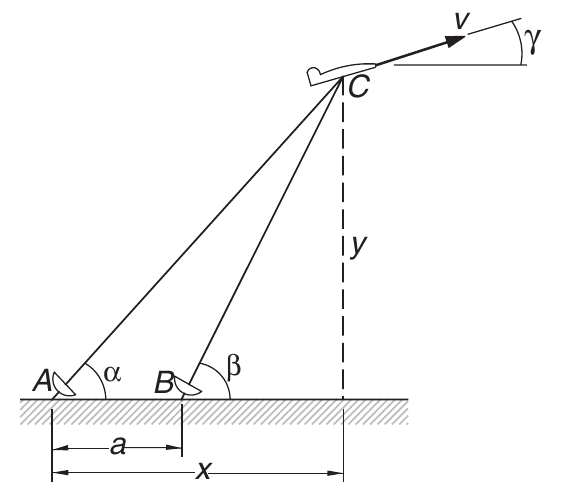


Las estaciones de radar $A$ y $B$, separadas por una distancia $a = 500 \, \text{m}$, rastrean un avión $C$ registrando los ángulos $\alpha$ y $\beta$ en intervalos de 1 segundo. Tres lecturas sucesivas son


```
data = {
    't (s)': [9, 10, 11],
    'alpha (°)': [54.80, 54.06, 53.34],
    'beta (°)': [65.59, 64.59, 63.62]
}

df = pd.DataFrame(data)
```

Calcular la velocidad $v$ del avión y el ángulo de ascenso $\gamma$ en $t = 10 \, \text{s}$. Las coordenadas del avión pueden expresarse como:

$$
x = a \frac{\tan \beta}{\tan \beta - \tan \alpha}
$$

$$
y = a \frac{\tan \alpha \tan \beta}{\tan \beta - \tan \alpha}
$$

In [ ]:
#Wow! Suena toda una misión avanzada de espionaje! Pulamos nuestras habilidades de agentes secretos.

#A) Observemos con lo que trabajaremos... (reconozcamos el terreno.)
data = {
    't (s)': [9, 10, 11],
    'alpha (°)': [54.80, 54.06, 53.34],
    'beta (°)': [65.59, 64.59, 63.62]
}

df = pd.DataFrame(data)
df

,t (s),alpha (°),beta (°)
0,9,54.80,65.59
1,10,54.06,64.59
2,11,53.34,63.62


In [ ]:
'''
El plan es el siguiente. Con los datos proporcionados, calcularemos las posicion (x,y) en cada uno de los tiempos.
Con estos datos, encontraremos su velocidad (cambio de posicición en el tiempo, AKA dxdt), y finalmente, con un poco
de geometría básica, hallaremos lambda!
'''

#Tengamos la data disponible a la mano.
t=np.array([9, 10, 11])
alpha=np.array([54.80, 54.06, 53.34])
beta=np.array([65.59, 64.59, 63.62])

alpha=alpha*(np.pi/180)  #No olvidemos que, nuestros clasicos np.tan trabajan en radianes!
beta=beta*(np.pi/180)
a=500

#Calculemos
x= a*( (np.tan(beta))/(np.tan(beta)-np.tan(alpha)) )
y= a* (   ( np.tan(beta)*np.tan(alpha)  )/(np.tan(beta)-np.tan(alpha))   )

#Y posteriormente, derivamos!

vx=np.gradient(x,t)  #Separamos nuestra velocidad en componentes...
vy=np.gradient(y,t)

#Y solo resta, hallar la velocidad total en el t=10! es decir
vtotal=np.sqrt( ((vx[1])**2) + ((vy[1])**2)   ) # [0] t=9, [1] t=10, [2] t=11 (Por los datos proporcionados)

#Y finalmente, nuestro lambda! que podemos hallar por la identidad tan(lambda)=vy/vx
lambd=np.arctan(vy[1]/vx[1])
#Por lo cual...

print(f'En t=10, la velocidad de la aeronave es de {round(vtotal,2)} m/s, con un ángulo de ascensión de {round(lambd *180/(np.pi),2)}°')

En t=10, la velocidad de la aeronave es de 50.1 m/s, con un ángulo de ascensión de 15.14°


# 4.
Se proporcionan los siguientes datos para la velocidad de un objeto en función del tiempo:

```
# Datos de tiempo y velocidad
t = np.array([0, 4, 8, 12, 16, 20, 24, 28, 32, 36])  # segundos
v = np.array([0, 34.7, 61.8, 82.8, 99.2, 112.0, 121.9, 129.7, 135.7, 140.4])  # m/s
```
- ¿Qué tan lejos viaja el objeto desde $t = 0$ hasta 28 s?
- ¿Cuál es la aceleración del objeto a $t = 28$ s?

In [ ]:
#Bueno... tenemos clásicas definiciones de física por aqui!
#A) La integral de la velocidad, nos proporciona la posición, y
#B) la derivada de la veloicdad, nos proporciona la aceleración!

t = np.array([0, 4, 8, 12, 16, 20, 24, 28, 32, 36])
v = np.array([0, 34.7, 61.8, 82.8, 99.2, 112.0, 121.9, 129.7, 135.7, 140.4])

#Como nos preguntan que tan lejos viaja, asumimos que x(t0)=0
'''
Plan; para la integral, vamos a usar Quad, por lo que necesitamos una función v(t), es decir, interpolar!'''

velocidad=CubicSpline(t,v,bc_type='natural') #Obtenemos nuestra función

xfinal=quad(velocidad,0,28)[0]  #Perfecto! Ya tenemos la distancia recorrida, ahora hallemos la aceleración en el instante 28

aceleracion=np.gradient(v,t)[np.where(t==28)[0]] #con el np.where, hallamos la aceleración EXACTAMENTE en t=28


#Y con todos los datos solicitados, tenemos entonces;
print(f'El objeto recorrió {round(xfinal,1)} metros en 28 segundos, tiempo en el cual su aceleración era de {aceleracion} m/s^2')

El objeto recorrió 2318.8 metros en 28 segundos, tiempo en el cual su aceleración era de [1.725] m/s^2


# 5.

El área superficial horizontal $A_s$ ($m^2$) de un lago a una profundidad particular puede calcularse a partir del volumen por diferenciación:

$$A_s(z) = -\frac{dV(z)}{dz}$$

donde:
- $V$ = volumen ($m^3$)
- $z$ = profundidad ($m$) medida desde la superficie hacia el fondo


La concentración promedio de una sustancia que varía con la profundidad $c$ ($g/m^3$) puede calcularse por integración:

$$c = \frac{\int_0^Z c(z)A_s(z) dz}{V_T}$$

donde:
- $Z$ = profundidad total (m)
- $V_T$ = volumen total del lago, dado también por:


$$V_T = \int_0^Z A_s(z) dz$$
Con base en los siguientes datos, determine la concentración promedio.
```
# Datos proporcionados
z = np.array([0, 4, 8, 12, 16])  # profundidad en metros
V = np.array([9.8175, 5.1051, 1.9635, 0.3927, 0.0000]) * 1e6  # volumen en m³
c = np.array([10.2, 8.5, 7.4, 5.2, 4.1])  # concentración en g/m³

# Parámetros importantes
Z = z[-1]  # profundidad total (16 m)
```

In [ ]:
#Bien! aqui hay que hacer calculos dentro de los calculos... adentro de otros calculos! Entonces vamos suave...
'''Si queremos concentración promedio, necesitamos As, y si queremos As, requerimos dVdz. asi que, comencemos por alli'''

# Datos proporcionados
z = np.array([0, 4, 8, 12, 16])  # profundidad en metros
V = np.array([9.8175, 5.1051, 1.9635, 0.3927, 0.0000]) * 1e6  # volumen en m³
c = np.array([10.2, 8.5, 7.4, 5.2, 4.1])  # concentración en g/m³

# Parámetros importantes
Z = z[-1]  # profundidad total (16 m)

###############################################################################

#Perfecto comencemos por obtener As, en forma de función, es decir As(z)

A=-np.gradient(V,z) #Derivamos el volumen con respecto a z
As=CubicSpline(z,A,bc_type='natural') #Y aqui convertimos nuestros discretos datos, en toda una función!

#Ahora, hallemos VT
VT=quad(As,0,Z)[0]

#Ahora funcionalicemos c
C=CubicSpline(z,c,bc_type='natural') #Bien! y finalmente...

ftotal=lambda z: As(z)*C(z)  #La función que le entra a nuestra integral! Por lo cual...


CPromedio= (  (quad(ftotal,0,Z))[0] /(VT)   ) #Calculamos!

print(f'La concentración promedio calculada es {round(CPromedio,4)}')

La concentración promedio calculada es 8.1261


# 6.
La función de onda del electrón en estado 2s ($n=2$, $l=0$, $m=0$) en unidades radiales adimensionales es:

$$\psi_{200}(r,\theta,\varphi) = \frac{1}{4\sqrt{2\pi}} (2 - r) e^{-r/2}$$

La probabilidad de encontrar el electrón entre $r=0$ y $r=R$ está dada por:

$$P(R) = \frac{1}{8} \int_0^R r^2 (2 - r)^2 e^{-r} dr$$

donde las integrales angulares contribuyen un factor de $4\pi$.

- Calcule las probabilidades $P(R)$ para $R \in [10,25]$ con incrementos de 1 utilizando los métodos:
    - Trapezoidal
    - Simpson
    - Cuadratura
    
Garantizando que el error sea menor a $\varepsilon = 10^{-6}$
- Calcule la integral radial desde $r=0$ hasta $+\infty$, verifique que la probabilidad total sea 1.



In [ ]:
#Bien! Hagamos nuestra función de probabilidad, y comencemos a comparar.
'''Plan; definamos nuestras funciones de integración con epsilons asociados, y realicemos nuestros incrementos'''

def trap(f,a,b,epsilon=1e-6):
  '''
  Integra la función f en el intervalo [a,b], con una tolerancia estandar (variable), con el metodo trapezoidal.
  entradas:
    f: funcion (calleable)
    a: limite inferior (float)
    b:limite superior (float)
    epsilon (opcional): tolerancia (float)
  salida:
    el valor aproximado de la integral con la tolerancia estandarizada
  '''

  n=10         #Con esto vamos a disminuir el paso (h), que es lo que mejora la presición, para alcanzar la tolerancia
  anterior=100000007 #Con este comparamos, hacemos un estandar poco probable que ocurra (ademas es primo!)

  while True:
    h=1/n  #Aqui definimos el h

    x=np.arange(a,b,h) #El arreglo en x(que depende del h)
    y=f(x) #en y

    integral=trapezoid(y,x)
    if abs(integral-anterior)<epsilon:  #Finaliza cuando alcanza la tolerancia
      return integral

    else:   #si no...
      n+=10  #aumentamos el n (es decir, achiquitamos el h)
      anterior=integral #y actualizamos


###############################################################################
'''
Bien, ahora para simpson es exactamente el mismo truco! solo cambiamos la funcion interior asociada
'''

def simp(f,a,b,epsilon=1e-6):
  '''
  Integra la función f en el intervalo [a,b], con una tolerancia estandar (variable), con el metodo de Simpson.
  entradas:
    f: funcion (calleable)
    a: limite inferior (float)
    b:limite superior (float)
    epsilon (opcional): tolerancia (float)
  salida:
    el valor aproximado de la integral con la tolerancia estandarizada
  '''

  n=10         #Con esto vamos a disminuir el paso (h), que es lo que mejora la presición, para alcanzar la tolerancia
  anterior=100000007 #Con este comparamos, hacemos un estandar poco probable que ocurra (ademas es primo!)

  while True:
    h=1/n  #Aqui definimos el h

    x=np.arange(a,b,h) #El arreglo en x(que depende del h)
    y=f(x) #en y

    integral=simpson(y,x)
    if abs(integral-anterior)<epsilon:  #Finaliza cuando alcanza la tolerancia
      return integral

    else:   #si no...
      n+=10  #aumentamos el n (es decir, achiquitamos el h)
      anterior=integral #y actualizamos

###############################################################################
'''
Finalmente, hacemos el metodo de cuadratura gaussiana, donde no variaremos un h, sino el grado del polinomio
de legendre, cambiando asi los pesos, en busca de nuestra tolerancia!
'''

def cuad(f,a,b,epsilon=1e-6):
    '''
    Calcula la integral de una función en el intervalo [-1, 1]
    utilizando cuadratura gaussiana.

    Entradas:
      f: la función a integrar (calleable)
      a: limite inferior (float)
      b: limite superior (float)
      epsilon(opcional): tolerancia (float)

    Salidas:
    Aproximación de la integral.

    '''
    n=1         #El chiste es el mismo, pero variaremos el objetivo
    anterior=100000007

    while True:
      # Obtener raíces y pesos del polinomio de Legendre, como de costumbre
      x, w = roots_legendre(n)

      # y ahora... la aproximación nueva! (con los cambios de variable para usar intervalos a,b)
      integral = np.sum(w * f( (((b-a)/2)*x) + ((a+b)/2) )) #podemos hacer esto sin problema, x y w estan vectorizados!
      integral=integral*((b-a)/2) #Y finalmente, este producto.

      if abs(integral-anterior)<epsilon: #confirmamos tolerancia
        return integral

      else:  #de lo contrario...
        n+=1  #aumentamos un grado al polinomio de legendre
        anterior=integral #actualizamos y volvemos a empezar!

###############################################################################
'''Y Perfecto! Bravo! Damas y caballeros, finalizamos de definir nuestras calculadoras de integrales con tolerancias!'''

'Y Perfecto! Bravo! Damas y caballeros, finalizamos de definir nuestras calculadoras de integrales con tolerancias!'

In [ ]:
'''
Bien, hagamos una clasica prueba con la gaussiana para confirmar que nuestras "calculadoras" funcionan
'''
fgauss=lambda x: np.exp(-x**2)
print(trap(fgauss,0,1),simp(fgauss,0,1),cuad(fgauss,0,1)) #Efectivamente, funciona nuestras calculadoras de integracion!

0.7466334064548293 0.7466334229237309 0.7468241267662482


In [ ]:
#Definamos nuestra función de probabilidad

def FProbabilidad(R):

  '''
  Calcula la probabilidad de encontrar un electron en un radio de 0 a R.
  entradas:
      R: limite de analisis (float)
  salidas:
    la probabilidad asociada al espacio proporcionado, con los siguientes metodos
    [0]Simpson, [1]Trapezoid, [2]Cuadratura Gaussiana. Las salidas se proporcionan en el orden mencionado
    (tupla)(%)
  '''

  f=lambda x: (x**2)*((2-x)**2)*(np.exp(-x))

  integralsimp=(1/8)* simp(f,0,R)
  integraltrap=(1/8)* trap(f,0,R)
  integralcuad=(1/8)* cuad(f,0,R)

  return integralsimp,integraltrap,integralcuad

erres=np.arange(10,25+1,1)
valoresSimpson=[]
valoresTrap=[]
valoresCuad=[]
for i in erres:
  valoresSimpson.append(FProbabilidad(i)[0] *100)
  valoresTrap.append(FProbabilidad(i)[1] *100)
  valoresCuad.append(FProbabilidad(i)[2] *100)

datos={'R':erres,'Simpson (%)':valoresSimpson,'Trapezoide (%)':valoresTrap,'Cuadratura (%)':valoresCuad}

probabilidades=pd.DataFrame(datos)
probabilidades

,R,Simpson (%),Trapezoide (%),Cuadratura (%)
0,10,94.045945,94.045945,94.048069
1,11,96.820706,96.820706,96.822292
2,12,98.354030,98.354030,98.355194
3,13,99.169932,99.169932,99.170770
4,14,99.590705,99.590704,99.591304
5,15,99.802074,99.802074,99.802490
6,16,99.905897,99.905897,99.906179
7,17,99.955907,99.955907,99.956106
8,18,99.979608,99.979607,99.979739
9,19,99.990679,99.990679,99.990760


In [ ]:
#y Finalmente, garanticemos la probabilidad del 100% (aunque, por los datos, es casi claro que funcionará)

f=lambda x: (x**2)*((2-x)**2)*(np.exp(-x))

probabilidadTotal=quad(f,0,np.inf)[0]*(1/8)*(100) #usamos quad que soporta np.infinity
probabilidadTotal #Voilà, tan preciso como claro.

100.0

# 7.
Una lámina cuadrada uniforme de metal flota inmóvil en el espacio:

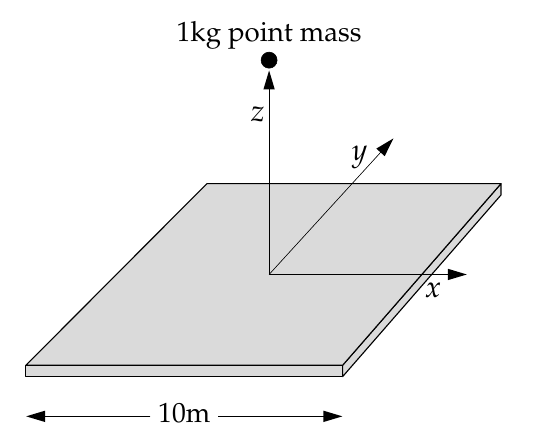

La lámina cuadrada tiene 10 m de lado y espesor despreciable. La componente de la fuerza gravitacional a lo largo del eje $z$ sobre una masa de prueba de 1 kg ubicada a distancia $z$ del centro de la lámina es:

$$F_z = G\sigma z \iint_{-L/2}^{L/2} \frac{dx \, dy}{(x^2 + y^2 + z^2)^{3/2}}$$

donde $G = 6.674 \times 10^{-11} \, \text{m}^3 \, \text{kg}^{-1} \, \text{s}^{-2}$, $\sigma = \frac{M}{L^2}$, $L = 10$ m y $M = 10,000$ kg.

- Calcular numéricamente esta integral doble.
- Graficar $F_z$ como función de $z$ desde $z=0$ hasta $z=10$ m


In [ ]:
#Perfecto, definamos nuestros datos clave

G=6.674*1e-11
M=10000         #Todo esta en MKS, podemos operar con tranqulidad
L=10
sigma=((M)/(L**2))

#Calculemos entonces primero la integral doble
flamina=lambda y,x,z: 1/(  ( (x**2) + (y**2) + (z**2) )**(3/2)  )#Cuidando el orden de integración, (el usa y,x, por lo cual invertimos)

#Bien, usemos double quad, por lo cual, hay que definir muy cuidadosamente las funciones como limites de integración.

a=-L/2
b=L/2

c=lambda x: -L/2
d=lambda x: L/2

#Y finalmente, demosle un valor estandar a z, para tener un valor
z=1
integral=dblquad(flamina,a,b,c,d,args=(z,))[0]
integral# Y Voilà, el calculo de la integral con un z arbitrario! (en este caso, z=1)

5.1701980162404

In [ ]:
#Bien, ahora comencemos a variar nuestros z, para observar el comportamiento gravitacional

def Fz(z,M=M,L=L):
  '''
  Calcula la fuerza gravitacional a lo largo del eje z en el centro de una lamina cuadrada de longitud L y masa M
  Entradas:
    z: Distancia de la lamina sobre el eje z (float)
    M(Opcional): masa de la lamina (float)
    L(Opcional): Longitud de los lados de la lamina (float) (lado individual)
  salidas:
    aproximación de la fuerza gravitacional con los parametros proporcionados.
  '''
  sigma=((M)/(L**2))
  a=-L/2
  b=L/2
  c=lambda x: -L/2
  d=lambda x: L/2


  flamina=lambda y,x,z: 1/(  ( (x**2) + (y**2) + (z**2) )**(3/2)  )
  integral=dblquad(flamina,a,b,c,d,args=(z,))[0]

  fuerzaG= G*sigma*z*integral
  return fuerzaG

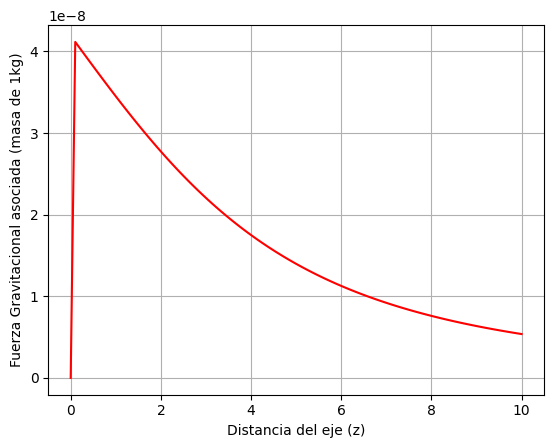

In [ ]:
'''
Procedemos entonces a graficar
'''
ztas=np.linspace(1e-20,10,100)
FG=[]
for i in ztas:
  FG.append(Fz(i))
plt.plot(ztas,FG,color='r')
plt.xlabel('Distancia del eje (z)')
plt.ylabel('Fuerza Gravitacional asociada (masa de 1kg)')
plt.grid()